In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble, model_selection, metrics
import matplotlib. pyplot as plt
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

In [3]:
df = pd.read_csv('data_clean_v7.csv', index_col=0)

# remove outlier - arrival_delay more than 120 mins
df = df[df['ARRIVAL_DELAY'] <= 120]

# chain 1 has no buffer 
df = df[df['CHAIN']!= 1]

# change buffer time to numerical 
df['BUFFER_TIME'] = df['BUFFER_TIME'].astype(np.float32)

df = df.dropna()

C:\Users\User\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [26]:
# Binning Scheduled Departure and Scheduled Arrival
df['SCHEDULED_DEPARTURE_bin'] = df['SCHEDULED_DEPARTURE'].apply(lambda x: '5am-7am' if x<='7:00:00' else
                                                               ('7am-9am' if x<='9:00:00' else
                                                               ('9am-11am' if x<='11:00:00' else
                                                               ('11am-1pm' if x<='13:00:00' else
                                                               ('1pm-3pm' if x<='15:00:00' else
                                                               ('3pm-5pm' if x<='17:00:00' else
                                                               ('5pm-7pm' if x<='19:00:00' else
                                                               ('7pm-9pm' if x<='21:00:00' else '9pm-12am'))))))))

df['SCHEDULED_ARRIVAL_bin'] = df['SCHEDULED_ARRIVAL'].apply(lambda x: '12am-5am' if x<='05:00:00' else
                                                               ('5am-7am' if x<='07:00:00' else
                                                               ('7am-9am' if x<='09:00:00' else
                                                               ('9am-11am' if x<='11:00:00' else
                                                               ('11am-1pm' if x<='13:00:00' else
                                                               ('1pm-3pm' if x<='15:00:00' else
                                                               ('3pm-5pm' if x<='17:00:00' else
                                                               ('5pm-7pm' if x<='19:00:00' else 
                                                                ('7pm-9pm' if x<='21:00:00' else '9pm-12am')))))))))

# remove columns not used
df = df.drop(columns=['SCHEDULED_ARRIVAL','TAIL_NUMBER','DATE','ROUTE','ARRIVAL_DELAY','DEPARTURE_TIME','SCHEDULED_DEPARTURE','ELAPSED_TIME','ARRIVAL_TIME','AIR_TIME','DEPARTURE_DELAY','REMAINING_BUFFER_TIME','SCHEDULED_TIME'])

In [27]:
x_columns = df.drop(['ARRIVAL_DELAY_GROUP'], axis=1)

In [5]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 820074 entries, 1 to 1022931
Data columns (total 32 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MONTH                               820074 non-null  int64  
 1   DAY                                 820074 non-null  int64  
 2   DAY_OF_WEEK                         820074 non-null  int64  
 3   ORIGIN_AIRPORT                      820074 non-null  object 
 4   DESTINATION_AIRPORT                 820074 non-null  object 
 5   DISTANCE                            820074 non-null  int64  
 6   vsby_origin                         820074 non-null  float64
 7   wxcodes_origin                      820074 non-null  float64
 8   tmpf_origin                         820074 non-null  float64
 9   dwpf_origin                         820074 non-null  float64
 10  relh_origin                         820074 non-null  float64
 11  sknt_origin              

In [28]:
df['vsby_origin'] = df['vsby_origin'].astype(np.float32)
df['wxcodes_origin'] = df['wxcodes_origin'].astype(np.float32)
df['tmpf_origin'] = df['tmpf_origin'].astype(np.float32)
df['dwpf_origin'] = df['dwpf_origin'].astype(np.float32)
df['relh_origin'] = df['relh_origin'].astype(np.float32)
df['sknt_origin'] = df['sknt_origin'].astype(np.float32)
df['gust_origin'] = df['gust_origin'].astype(np.float32)
df['mslp_origin'] = df['mslp_origin'].astype(np.float32)
df['vsby_destination'] = df['vsby_destination'].astype(np.float32)
df['wxcodes_destination'] = df['wxcodes_destination'].astype(np.float32)
df['tmpf_destination'] = df['tmpf_destination'].astype(np.float32)
df['dwpf_destination'] = df['dwpf_destination'].astype(np.float32)
df['relh_destination'] = df['relh_destination'].astype(np.float32)
df['sknt_destination'] = df['sknt_destination'].astype(np.float32)
df['gust_destination'] = df['gust_destination'].astype(np.float32)
df['mslp_destination'] = df['mslp_destination'].astype(np.float32)
df['Hourly_number_of_departure_flights'] = df['Hourly_number_of_departure_flights'].astype(np.int32)
df['Hourly_number_of_arrival_flights'] = df['Hourly_number_of_arrival_flights'].astype(np.int32)
df['ARRIVAL_DELAY_GROUP'] = df['ARRIVAL_DELAY_GROUP'].astype(np.int32)
df['PRIOR_DELAY_GROUP'] = df['PRIOR_DELAY_GROUP'].astype(np.int32)
df['CHAIN'] = df['CHAIN'].astype(np.int32)
df['departure_KPI'] = df['departure_KPI'].astype(np.float32)
df['arrival_KPI'] = df['arrival_KPI'].astype(np.float32)
df['MONTH'] = df['MONTH'].astype(np.int32)
df['DAY'] = df['DAY'].astype(np.int32)
df['DAY_OF_WEEK'] = df['DAY_OF_WEEK'].astype(np.int32)

In [7]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 820074 entries, 1 to 1022931
Data columns (total 32 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MONTH                               820074 non-null  int32  
 1   DAY                                 820074 non-null  int32  
 2   DAY_OF_WEEK                         820074 non-null  int32  
 3   ORIGIN_AIRPORT                      820074 non-null  object 
 4   DESTINATION_AIRPORT                 820074 non-null  object 
 5   DISTANCE                            820074 non-null  int64  
 6   vsby_origin                         820074 non-null  float32
 7   wxcodes_origin                      820074 non-null  float32
 8   tmpf_origin                         820074 non-null  float32
 9   dwpf_origin                         820074 non-null  float32
 10  relh_origin                         820074 non-null  float32
 11  sknt_origin              

### define the functions for mean encoding, hyperparameter tuning, and calculate prediction accuracy by Chain number

In [20]:
def mean_encoding(data, n):  
    
    data = data.loc[data['CHAIN'] <= n]
    
    # split data to train and test
    train, test = model_selection.train_test_split(data, test_size = 0.2, stratify = data['ARRIVAL_DELAY_GROUP'], random_state = 610)
    
    # compute the mean encoding value for categorical features in train data
    Mean_encoded_subject = train.groupby(['ORIGIN_AIRPORT'])['ARRIVAL_DELAY_GROUP'].mean().to_dict() 
    train['mean_encoding_origin'] =  train['ORIGIN_AIRPORT'].map(Mean_encoded_subject) 
    Mean_encoded_subject = train.groupby(['DESTINATION_AIRPORT'])['ARRIVAL_DELAY_GROUP'].mean().to_dict() 
    train['mean_encoding_destination'] =  train['DESTINATION_AIRPORT'].map(Mean_encoded_subject) 
    Mean_encoded_subject = train.groupby(['SCHEDULED_ARRIVAL_bin'])['ARRIVAL_DELAY_GROUP'].mean().to_dict() 
    train['scheduled_arrival_bin'] =  train['SCHEDULED_ARRIVAL_bin'].map(Mean_encoded_subject) 
    Mean_encoded_subject = train.groupby(['SCHEDULED_DEPARTURE_bin'])['ARRIVAL_DELAY_GROUP'].mean().to_dict() 
    train['scheduled_departure_bin'] =  train['SCHEDULED_DEPARTURE_bin'].map(Mean_encoded_subject) 
    #train = train.dropna()
    
    # assign the mean encoding value obtained from training data to test categorical
    mean_encoding_origin = train[['ORIGIN_AIRPORT', 'mean_encoding_origin']].drop_duplicates()
    mean_encoding_detination = train[['DESTINATION_AIRPORT','mean_encoding_destination']].drop_duplicates()
    mean_encoding_scheduled_arrival_bin = train[['SCHEDULED_ARRIVAL_bin','scheduled_arrival_bin']].drop_duplicates()
    mean_encoding_scheduled_departure_bin = train[['SCHEDULED_DEPARTURE_bin','scheduled_departure_bin']].drop_duplicates()
    
    test = test.merge(mean_encoding_origin, how = 'left', left_on =['ORIGIN_AIRPORT'], right_on = ['ORIGIN_AIRPORT'])
    test = test.merge(mean_encoding_detination, how = 'left', left_on =['DESTINATION_AIRPORT'], right_on = ['DESTINATION_AIRPORT'])
    test = test.merge(mean_encoding_scheduled_departure_bin, how = 'left', left_on =['SCHEDULED_DEPARTURE_bin'], right_on = ['SCHEDULED_DEPARTURE_bin'])
    test = test.merge(mean_encoding_scheduled_arrival_bin, how = 'left', left_on =['SCHEDULED_ARRIVAL_bin'], right_on = ['SCHEDULED_ARRIVAL_bin'])
    
    #drop the categorical features from train and test
    train = train.drop(columns=['ORIGIN_AIRPORT','DESTINATION_AIRPORT','SCHEDULED_DEPARTURE_bin','SCHEDULED_ARRIVAL_bin'])
    train = train.dropna()
    test = test.drop(columns=['ORIGIN_AIRPORT','DESTINATION_AIRPORT','SCHEDULED_DEPARTURE_bin','SCHEDULED_ARRIVAL_bin'])
    test = test.dropna()
    
    return (train, test)

In [4]:
def Random_forest_tuning(x, y):
    
    rf = RandomForestClassifier()
    
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]

    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
    max_depth.append(None)
    
    # Number of features to consider at every split
    #max_features = ['auto', 'sqrt']
    ## auto is same as sqrt

    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]

    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]

    # Method of selecting samples for training each tree
    bootstrap = [True, False]

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    rf_base = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = random_grid, n_iter = 10, cv = 2, verbose=2, random_state=42, n_jobs = -1)

    # Fit the random search model
    rf_random.fit(x, y)
    best_params = rf_random.best_params_
    print(best_params)
    rf_tuned = rf_random.best_estimator_
    feat_importances = pd.Series(rf_tuned.feature_importances_, index=x_columns.columns)
    feat_importances.plot(kind='barh',figsize=(5,7))
    plt.show()

    return rf_tuned

In [22]:
# compute the accuracy based on chain number 
def accuracy_chain(data, n):
    
    train, test = mean_encoding(data, n)
    
    df_x = train.drop(['ARRIVAL_DELAY_GROUP'], axis=1)
    x_train = df_x.values
    y_train = train[['ARRIVAL_DELAY_GROUP']].values.ravel()
    
    classifier_tuned = Random_forest_tuning(x_train, y_train)
    
    x_test = test.drop(['ARRIVAL_DELAY_GROUP'], axis=1).values
    y_test = test[['ARRIVAL_DELAY_GROUP']].values.ravel()
    
    score = classifier_tuned.score(x_test, y_test)
    y_pred = classifier_tuned.predict(x_test)
    rmse = metrics.mean_squared_error(y_test, y_pred, squared = True)

    return (score, rmse)

## Run for different Chain numbers

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:  7.9min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 11.0min finished


{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


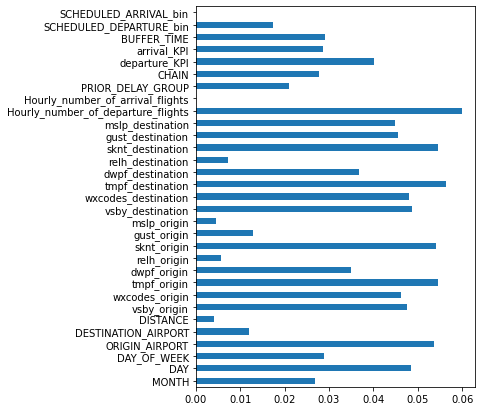

(0.5667370267825325, 1.2626716741138737)

In [9]:
accuracy_chain(df, 2)

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed: 11.3min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 17.5min finished


{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}


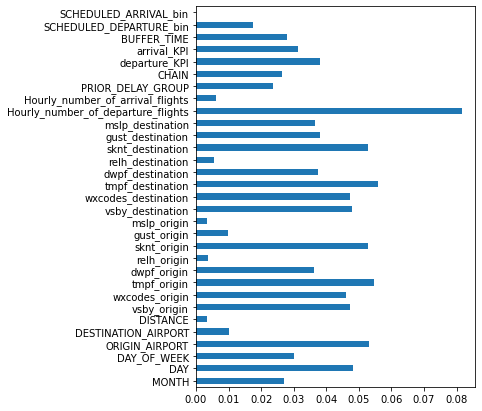

(0.5452533407572383, 1.245336859688196)

In [17]:
accuracy_chain(df, 3)

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed: 13.7min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 26.8min finished


{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}


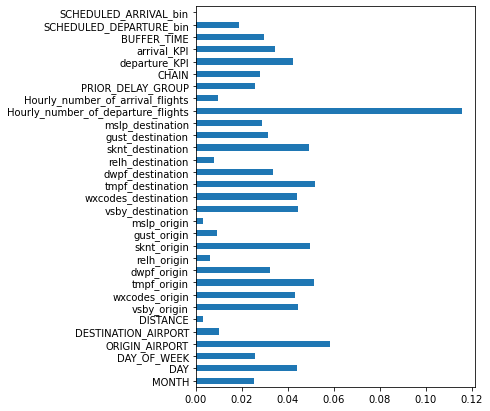

(0.5321694148076301, 1.3385158136969628)

In [18]:
accuracy_chain(df, 4)

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed: 20.5min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 34.8min finished


{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}


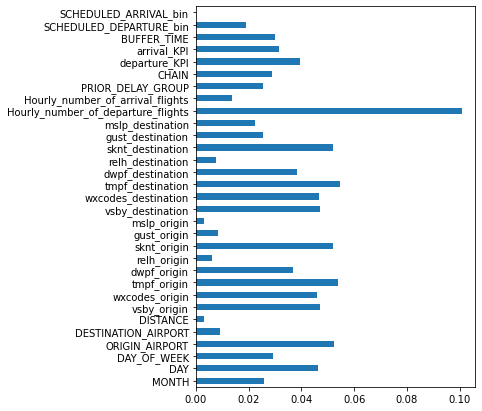

(0.5264573515372842, 1.404648977921901)

In [19]:
accuracy_chain(df, 5)

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed: 21.8min remaining:  5.5min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 30.6min finished


{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}


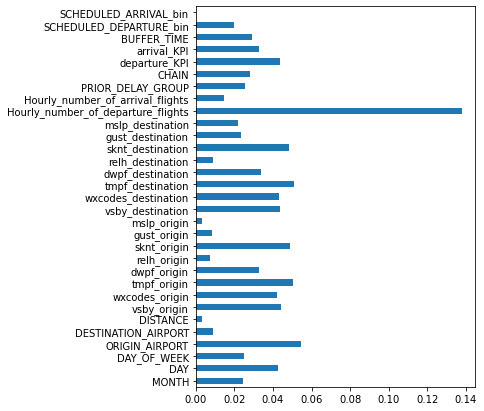

(0.5230407377300409, 1.3914859876600791)

In [20]:
accuracy_chain(df, 6)

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed: 22.4min remaining:  5.6min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 32.6min finished


{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}


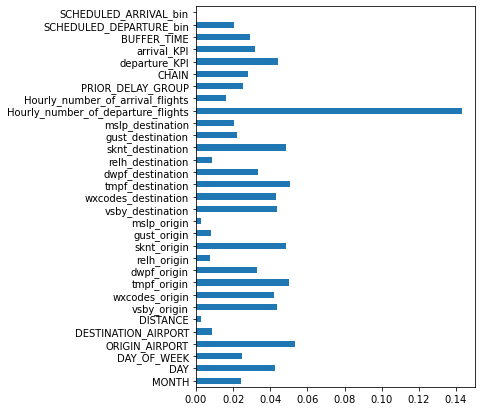

(0.5217653223225547, 1.4336121587108352)

In [21]:
accuracy_chain(df, 7)

C:\Users\lohro\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\lohro\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\lohro\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  7.8min remaining: 11.8min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 25.0min finished


{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}


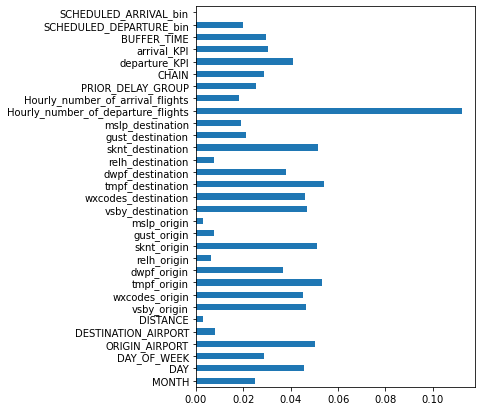

(0.5204497031247122, 1.3960506683531557)

In [11]:
accuracy_chain(df, 8)

C:\Users\lohro\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\lohro\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\lohro\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  7.9min remaining: 11.8min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 25.5min finished


{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}


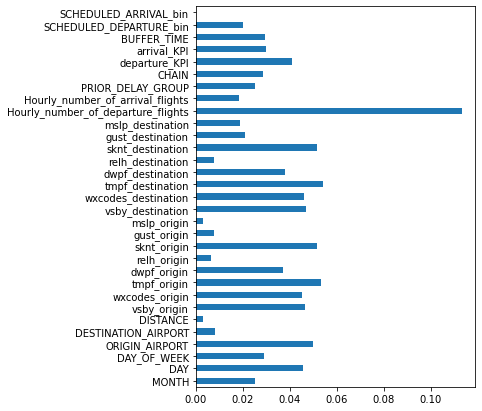

(0.5200798188819254, 1.4030853537233556)

In [12]:
accuracy_chain(df, 9)

C:\Users\lohro\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\lohro\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\lohro\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  7.9min remaining: 11.9min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 25.1min finished


{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}


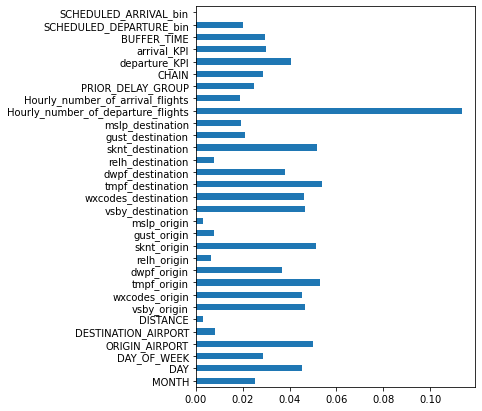

(0.5218984555537264, 1.3828678044229819)

In [13]:
accuracy_chain(df, 10)

C:\Users\lohro\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\lohro\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\lohro\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  7.9min remaining: 11.9min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 35.2min finished


{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}


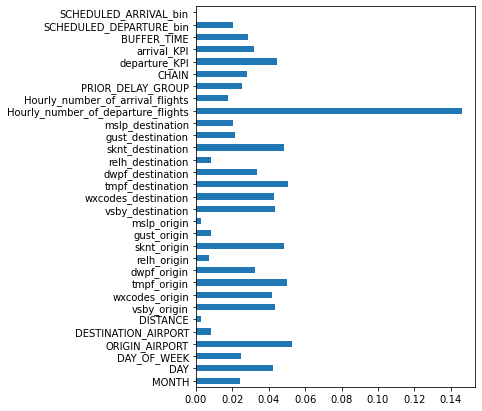

(0.521677895314453, 1.4043898423924641)

In [14]:
accuracy_chain(df, 11)